In [2]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
import scipy as sp
# import scipy.sparse
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
# import graphlab as gl
import sklearn.metrics
import ast
%matplotlib inline

from matrix_factorization_recommender import MatrixFactorizationRecommender
from simple_averaging_recommender import SimpleAveragingRecommender

In [3]:
businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')

phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
reviews_train, reviews_test = train_test_split_reviews(phoenix_reviews)

In [4]:
phoenix_restaurants.head(2)

,attributes,business_id,categories,city,full_address,hours,latitude,longitude,name,neighborhoods,open,review_count,stars,state,type,location
2377,"{'Accepts Credit Cards': True, 'Noise Level': ...",2377,"['Sandwiches', 'Pizza', 'Chicken Wings', 'Rest...",Phoenix,"2819 N Central Ave\nPhoenix, AZ 85004","{'Monday': {'close': '00:00', 'open': '10:00'}...",33.479482,-112.073681,Domino's Pizza,[],True,20,3.0,AZ,business,Phoenix
2378,"{'Accepts Credit Cards': True, 'Noise Level': ...",2378,"['American (New)', 'Sandwiches', 'Restaurants']",Phoenix,"1850 N Central Ave\nPhoenix, AZ 85004",{},33.468547,-112.075085,Viad Tower Restaurants,[],True,6,3.5,AZ,business,Phoenix


### clean the data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x106b2bb10>]], dtype=object)

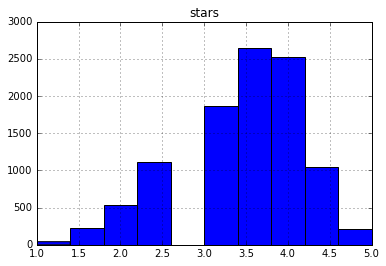

In [5]:
phoenix_restaurants.hist('stars')

Note: looks almost normal!! Wooop

In [6]:
# phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
# interesting columns
columns_of_interest = ['business_id',
                     'attributes',
                     'categories',
                     'city',
#                      'hours', # looks complicated
                     'latitude',
                     'longitude',
                     'neighborhoods',
                     'open',
                     'review_count',
                     'stars']
phoenix_restaurants = phoenix_restaurants[columns_of_interest]

def flatten(dct, separator='_'):
    """A fast way to flatten a dictionary,"""
    res = {}
    queue = [('', dct)]

    while queue:
        prefix, d = queue.pop()
        for k, v in d.items():
            key = prefix + k
            if not isinstance(v, dict):
                res[key] = [v]
            else:
                queue.append((key + separator, v))
    return res

def parse_data(row):
    attribs = flatten(ast.literal_eval(row.attributes))
    categories = ast.literal_eval(row.categories)
    neighborhoods = ast.literal_eval(row.neighborhoods)
    attributes = pd.DataFrame.from_dict(attribs, orient='columns')
    categories = pd.DataFrame.from_dict(dict([[c, [1]] for c in categories]))
    neighborhoods = pd.DataFrame.from_dict(dict([[n, [1]] for n in neighborhoods]))
    
    row = row.drop(['attributes', 'categories', 'neighborhoods'])
    if (neighborhoods.shape[0] > 0) & (attributes.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], neighborhoods.iloc[0], pd.get_dummies(attributes).iloc[0]), axis=0)
    elif (neighborhoods.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], neighborhoods.iloc[0]), axis=0)
    elif (attributes.shape[0] > 0):
        result = pd.concat((row, categories.iloc[0], pd.get_dummies(attributes).iloc[0]), axis=0)
    else:
        result = pd.concat((row, categories.iloc[0]), axis=0)
    return result

phoenix_update = phoenix_restaurants.apply(parse_data,axis=1,)
phoenix_update = pd.concat((phoenix_update, pd.get_dummies(phoenix_update['city'])), axis=1)
phoenix_update = phoenix_update.drop('city', axis=1)
phoenix_update = phoenix_update.fillna(0)
phoenix_update.head(2)

,Accepts Credit Cards,Accepts Insurance,Active Life,Adult Entertainment,Afghan,African,Ages Allowed_18plus,Ages Allowed_21plus,Ages Allowed_allages,Airport Lounges,...,Surprise,Tempe,Tolleson,Tonopah,Tonto Basin,Tortilla Flat,Wickenburg,Youngtown,glendale,phoenix
2377,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2378,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
phoenix_update.head(2)

,Accepts Credit Cards,Accepts Insurance,Active Life,Adult Entertainment,Afghan,African,Ages Allowed_18plus,Ages Allowed_21plus,Ages Allowed_allages,Airport Lounges,...,Surprise,Tempe,Tolleson,Tonopah,Tonto Basin,Tortilla Flat,Wickenburg,Youngtown,glendale,phoenix
2377,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2378,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
phoenix_update.head(2)

,Accepts Credit Cards,Accepts Insurance,Active Life,Adult Entertainment,Afghan,African,Ages Allowed_18plus,Ages Allowed_21plus,Ages Allowed_allages,Airport Lounges,...,Surprise,Tempe,Tolleson,Tonopah,Tonto Basin,Tortilla Flat,Wickenburg,Youngtown,glendale,phoenix
2377,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2378,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
las = sklearn.linear_model.Lasso(alpha=10**(-2.5))
las.fit(phoenix_update.drop('stars', axis=1), phoenix_update['stars'].values)
las.coef_

array([ -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   1.46224072e-01,  -3.76143418e-02,
         8.43333856e-02,   0.00000000e+00,   0.00000000e+00,
         7.88437831e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -5.75948204e-02,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
        -8.09566106e-02,   0.00000000e+00,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -0.00000000e+00,  -2.53287821e-02,  -0.00000000e+00,
        -0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [9]:
x = phoenix_update.drop('stars', axis=1)
x.columns[las.coef_ > 0]

Index([u'Alcohol_beer_and_wine', u'Alcohol_none', u'Ambience_divey', u'Cafes',
       u'Caters', u'Food', u'Good For Groups', u'Good For_dinner',
       u'Good For_lunch', u'Greek', u'Mediterranean', u'Noise Level_quiet',
       u'Outdoor Seating', u'Parking_lot', u'Parking_street',
       u'Takes Reservations', u'Wheelchair Accessible', u'business_id',
       u'open', u'review_count', u'Phoenix', u'Scottsdale'],
      dtype='object')

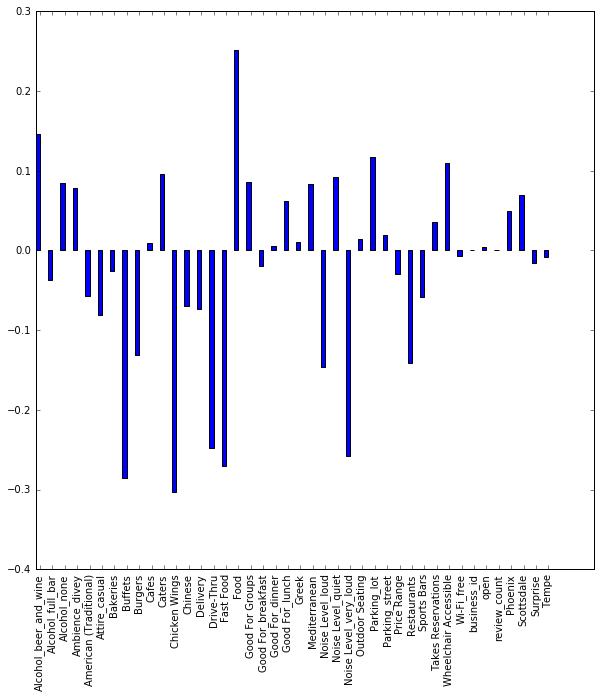

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ind = np.arange(len(las.coef_[las.coef_ != 0]))
width = 0.35
ax.bar(ind, las.coef_[las.coef_ != 0], width)
ax.set_xticks(ind + width)
ax.set_xticklabels(x.columns[las.coef_ != 0])
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=10)
plt.show()

In [11]:
scores = []
i_vals = np.logspace(-5,5,15)
for i in i_vals:
    las = sklearn.linear_model.Ridge(alpha=i)
    las.fit(X_train, y_train)
    scores.append(las.score(X_test, y_test))

NameError: name 'X_train' is not defined

In [ ]:
plt.semilogx(i_vals, scores)

In [ ]:
las = sklearn.linear_model.Ridge(alpha=10**1.2)
las.fit(X_train, y_train)
las.coef_[las.coef_>0.1]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
thresh = 0.18
selected_coef = (las.coef_ > thresh)|(las.coef_ < -thresh)
ind = np.arange(len(las.coef_[selected_coef]))
width = 0.35
ax.bar(ind, las.coef_[selected_coef], width)
ax.set_xticks(ind + width)
ax.set_xticklabels(x.columns[selected_coef])
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=10)
plt.show()

## Content based filtering

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#     phoenix_update.drop('stars', axis=1), phoenix_update['stars'].values, test_size=0.3, random_state=0)
# print 'Train shape: ', X_train.shape
# print 'Test shape: ', X_test.shape
# phoenix_update['business_id'].shape
# X_train['business_id'].isin(X_test['business_id'])
# phoenix_update[phoenix_update['business_id'].isin(phoenix_update['business_id'].unique())].shape
phoenix_restaurants.shape

In [ ]:
x_train = pd.merge(reviews_train, phoenix_update, how='inner', on='business_id')
x_test = pd.merge(reviews_test, phoenix_update, how='inner', on='business_id')

y_train = x_train['stars_x']
y_test = x_test['stars_x']

bus_rating_train = x_train['stars_y']
bus_rating_test = x_test['stars_y']

# x_train = x_train.drop(['stars_x', 'stars_y'], axis=1)
# x_test = x_test.drop(['stars_x', 'stars_y'], axis=1)
None

In [ ]:
x_train.head(2)

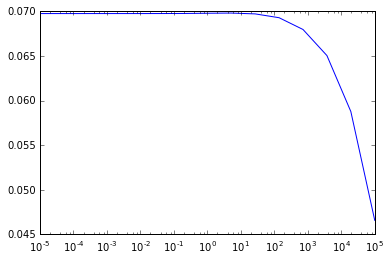

In [159]:
scores = []
i_vals = np.logspace(-5,5,15)
for i in i_vals:
    las = sklearn.linear_model.Ridge(alpha=i)
    las.fit(x_train, y_train)
    scores.append(las.score(x_test, y_test))
plt.semilogx(i_vals, scores)

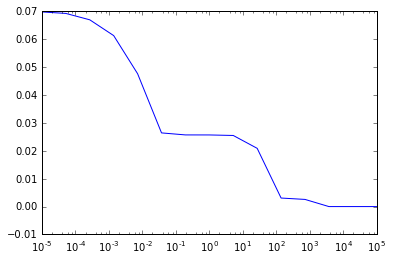

In [160]:
scores = []
i_vals = np.logspace(-5,5,15)
for i in i_vals:
    las = sklearn.linear_model.Lasso(alpha=i)
    las.fit(x_train, y_train)
    scores.append(las.score(x_test, y_test))
plt.semilogx(i_vals, scores)

In [161]:
las = sklearn.linear_model.Ridge(alpha=1)
las.fit(x_train, y_train)
np.sqrt(sklearn.metrics.mean_squared_error(y_test, las.predict(x_test)))

1.3058334681603359

In [165]:
las = sklearn.linear_model.Lasso(alpha=1)
las.fit(x_train, bus_rating_train)
np.sqrt(sklearn.metrics.mean_squared_error(bus_rating_test, las.predict(x_test)))

0.53052824558950096

Matrix Factorisation Blank

In [7]:
# phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)
# interesting columns
columns_of_interest = ['user_id',
                    'average_stars',
                     'compliments',
                     'elite',
                     'fans',
                    'votes',
#                      'hours', # looks complicated
                     'review_count',
#                      'yelping_since'
                      ]
phoenix_users = phoenix_users[columns_of_interest]

def flatten(dct, separator='_'):
    """A fast way to flatten a dictionary,"""
    res = {}
    queue = [('', dct)]

    while queue:
        prefix, d = queue.pop()
        for k, v in d.items():
            key = prefix + k
            if not isinstance(v, dict):
                res[key] = [v]
            else:
                queue.append((key + separator, v))
    return res

def parse_data(row):
    compliments = pd.DataFrame.from_dict(flatten(ast.literal_eval(row.compliments)), orient='columns')
    votes = pd.DataFrame.from_dict(flatten(ast.literal_eval(row.votes)), orient='columns')
    elite = pd.DataFrame.from_dict(dict([['elite_{}'.format(e), [1]] for e in ast.literal_eval(row.elite)]))
    
    compliments.columns = ['compliment_' + c for c in compliments.columns]
    votes.columns = ['vote' + v for v in votes.columns]
    
    row = row.drop(['compliments', 'votes', 'elite'])
 
    if (elite.shape[0] > 0) & (votes.shape[0] > 0) & (compliments.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0], votes.iloc[0],  compliments.iloc[0]), axis=0)
    elif (elite.shape[0] > 0) & (votes.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0], votes.iloc[0]), axis=0)
    elif (elite.shape[0] > 0) & (compliments.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0], compliments.iloc[0]), axis=0)
    elif (votes.shape[0] > 0) & (compliments.shape[0] > 0):
        result = pd.concat((row, votes.iloc[0], compliments.iloc[0]), axis=0)
    elif (elite.shape[0] > 0):
        result = pd.concat((row, elite.iloc[0]), axis=0)
    elif (votes.shape[0] > 0):
        result = pd.concat((row, votes.iloc[0]), axis=0)    
    elif (compliments.shape[0] > 0):
        result = pd.concat((row, compliments.iloc[0]), axis=0)
    else:
        result = row
        
    return result

phoenix_users_update = phoenix_users.apply(parse_data,axis=1,)
phoenix_users_update = phoenix_users_update.fillna(0)
phoenix_users_update.head(2)

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,elite_2013,elite_2014,elite_2015,elite_2016,fans,review_count,user_id,votecool,votefunny,voteuseful
1,3.67,1675,204,594,1111,38,137,611,361,970,...,1,1,1,1,1345,1292,1,12091,8399,15242
2,3.68,134,22,96,99,4,18,79,27,86,...,1,1,1,0,105,395,2,657,722,1349


In [10]:
# X_data = pd.merge((phoenix_users_update, reviews), how='inner', on='user_id')
X_data = pd.merge(phoenix_update, reviews, how='inner', on='business_id')
X_data = X_data.drop_duplicates(subset=['user_id', 'business_id'])
X_data.head(2)

,Accepts Credit Cards,Accepts Insurance,Active Life,Adult Entertainment,Afghan,African,Ages Allowed_18plus,Ages Allowed_21plus,Ages Allowed_allages,Airport Lounges,...,Tortilla Flat,Wickenburg,Youngtown,glendale,phoenix,user_id,year,month,day,stars_y
0,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,547856,2010,4,2,4
2,True,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,658647,2010,11,2,5


In [ ]:
## make the factor matrix for SVD
factor_matrix = X_data.pivot(index='user_id', columns='business_id', values='stars_x')
factor_matrix.set_index('user_id')

In [ ]:
## add all of the business and user data to the factor matrix
X_data.set_index('user_id')
X_data = X_data.join(factor_matrix)
# X_data = pd.merge(phoenix_users_update, X_data, how='inner', on='user_id')
X_data.head(2)

In [1]:
# train_data, test_data = train_test_split(X_data, )
factor_matrix.head(1)

NameError: name 'factor_matrix' is not defined

In [51]:
X = phoenix_reviews.drop_duplicates(['user_id', 'business_id'])
# X = X.pivot(index='user_id', columns='business_id', values='stars')

In [ ]:
X = X.fillna(0)

model = NMF(n_components=2, init='random', random_state=0)
model.fit(X)

In [210]:
model.components_

array([[ 2.05196954,  0.        ],
       [ 0.        ,  2.58176394]])

In [8]:
#get SVD components from train matrix. Choose k.
X = X.fillna(0)
u, s, vt = np.linalg.svd(X, k = 20)

In [19]:
X = x_train.drop_duplicates(subset=['user_id', 'business_id'])
X = X.iloc[0:10].pivot(index='user_id', columns='business_id', values='stars_x')
X = X.fillna(0)

NameError: name 'x_train' is not defined

In [ ]:
from sklearn import cross_validation as cv
from sklearn.metrics.pairwise import pairwise_distances

train_data, test_data = cv.train_test_split(X, test_size=0.25)

user_similarity = pairwise_distances(train_data, metric='cosine')
item_similarity = pairwise_distances(train_data.T, metric='cosine')

In [ ]:
n_users, n_items = train_data.shape
sparsity=round(1.0-len(train_data)/float(n_users*n_items),3)
print 'The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%'

In [ ]:
u, s, vt = svds(train_data, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print 'User-based CF MSE: ' + str(rmse(X_pred, test_data))

In [5]:
test = pd.read_csv('./test.csv')

/Users/nickhoernle/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,14,15,16,17,18,19,20,21,22,39,68,99,112,113,114,115,116,117,118,160,234,235,236,238,239,240,241,242) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
test.head(1)

,Unnamed: 0,Accepts Credit Cards,Accepts Insurance,Active Life,Adult Entertainment,Afghan,African,Ages Allowed_18plus,Ages Allowed_21plus,Ages Allowed_allages,...,85477,85478,85495,85501,85517,85656,85674,85769,85889,85897
0,0,True,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
phoenix_update = phoenix_update.rename(columns={'review_count':'bus_review_count', 'stars':'bus_stars'})
X.reset_index()
X.set_index('business_id')
X = X.join(phoenix_update.set_index('business_id'))
X.drop_duplicates(subset=['user_id', 'business_id'])
X.reset_index()

In [53]:
X.head(2)

,user_id,business_id,year,month,day,stars,Accepts Credit Cards,Accepts Insurance,Active Life,Adult Entertainment,...,Surprise,Tempe,Tolleson,Tonopah,Tonto Basin,Tortilla Flat,Wickenburg,Youngtown,glendale,phoenix
46032,547856,2377,2010,4,2,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46034,658647,2377,2010,11,2,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2))
tfidf = vectorizer.fit_transform(data)

NameError: name 'TfidfVectorizer' is not defined

In [7]:
from scipy.sparse import csr_matrix

user_u = list(np.sort(phoenix_reviews.user_id.unique()))
bus_u = list(np.sort(phoenix_reviews.business_id.unique()))

data = reviews_train['stars'].tolist()
row = reviews_train.user_id.astype('category', categories=user_u).cat.codes
col = reviews_train.business_id.astype('category', categories=bus_u).cat.codes
sparse_matrix_train = csr_matrix((data, (row, col)), shape=(len(user_u), len(bus_u)), dtype=np.float32)

data = reviews_test['stars'].tolist()
row = reviews_test.user_id.astype('category', categories=user_u).cat.codes
col = reviews_test.business_id.astype('category', categories=bus_u).cat.codes
sparse_matrix_test = csr_matrix((data, (row, col)), shape=(len(user_u), len(bus_u)), dtype=np.float32)

sparse_matrix_train[sparse_matrix_train>5]=5.
sparse_matrix_test[sparse_matrix_test>5]=5.

In [ ]:
user_cols = list(np.sort(phoenix_users_update.columns))
row_data = list(np.sort(phoenix_users_update.user_id.unique()))

In [8]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].tolist()
    ground_truth = ground_truth[ground_truth.nonzero()].tolist()[0]
    return np.sqrt(mean_squared_error(prediction, ground_truth))

In [7]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(sparse_matrix_train, k = 100)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

In [8]:
print 'User-based CF MSE: ' + str(rmse(X_pred, sparse_matrix_test))

User-based CF MSE: 3.9255329189


In [ ]:
model = NMF(n_components = 100, init='nndsvd', random_state=0)
model.fit(sparse_matrix_train)
W = model.transform(sparse_matrix_train) 
H = model.components_

/Users/nickhoernle/anaconda2/lib/python2.7/site-packages/sklearn/decomposition/nmf.py:997: DeprecationWarning: Controlling regularization through the sparseness, beta and eta arguments is only available for 'pg' solver, which will be removed in release 0.19. Use another solver with L1 or L2 regularization instead.
  " regularization instead.", DeprecationWarning)


In [8]:
nR = W.dot(H)

In [9]:
print 'User-based CF MSE: ' + str(rmse(nR, sparse_matrix_test))

User-based CF MSE: 4.00065208347


/Users/nickhoernle/anaconda2/lib/python2.7/site-packages/scipy/sparse/compressed.py:213: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  ", try using != instead.", SparseEfficiencyWarning)


In [ ]:
sparse_matrix_train.shape

In [ ]:
sparse_matrix_test.shape

In [1]:
import nimfa

V = nimfa.examples.medulloblastoma.read(normalize=True)

lsnmf = nimfa.Lsnmf(V, seed='random_vcol', rank=50, max_iter=100)
lsnmf_fit = lsnmf()

In [8]:
lsnmf = nimfa.Lsnmf(V, seed='random_vcol', rank=50, max_iter=100)
lsnmf_fit = lsnmf()

In [9]:
lsnmf_fit

<nimfa.models.mf_fit.Mf_fit instance at 0x106780368>

L1 Lin Reg

(array([ 253747.,       0.,  179523.,       0.,       0.,   81641.,
              0.,   60895.,       0.,   71986.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

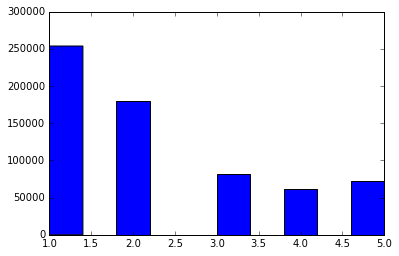

In [33]:
phoenix_reviews['stars'] = (6- phoenix_reviews['stars']).values

In [41]:
left = phoenix_users_update.set_index('user_id')
right = reviews_train.set_index('user_id')
res = left.join(right)

In [45]:
left = reviews_train.rename(columns={'review_count':'bus_review_count', 'stars':'bus_stars'})
left = left.set_index('business_id')
right = res.set_index('business_id')
res = left.join(right)

In [61]:
X = res.drop('stars', axis=1)
y = res['stars']
X = X.fillna(0)
y = y.fillna(0)

In [62]:
scores = []
i_vals = np.logspace(-5,5,15)
for i in i_vals:
    las = sklearn.linear_model.Lasso(alpha=i)
    las.fit(X, y)
    s = las.score(X, y)
    scores.append(s)
    print s
plt.semilogx(i_vals, scores)

/Users/nickhoernle/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.364102821816
0.363949418371
0.363607910135
0.363136541781
0.36248243265
0.35912735206


KeyboardInterrupt: 